In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import datajoint as dj
import pathlib
import itertools
import re

dj.config["enable_python_native_blobs"] = True

In [3]:
schema = dj.schema('photonics')
schema.spawn_missing_classes()

Connecting dimitri@localhost:3306


In [14]:
@schema
class Design(dj.Lookup):
    definition = """
    design : smallint     # design number
    ---
    design_title : varchar(255)    
    design_description : varchar(1000)
    design_path    : varchar(255)  
    geometry_file  : varchar(255)
    center_offset  : blob   # offset from legacy implementation
    efields : blob   # efield selection
    dfields : blob   # dfield selection
    """
    
    contents = [
        (1, '8-emitter-design', '', 'Design1/matrix_8pix_random_1200x1200x400_15-04-17', 
         'geometry.csv', (600, 600, 0), 
         (0,), (0,)),
        (3, "Wesley Sacher's shaped fields", "", 
         "Design3/matrix_wesley1_revised_revised_1000x1000x1000_15-12-15", 
         "geometry_beams_as_emitters_wesley1_1000x1000x1000.csv", (550, 510, 0), 
         (10, 11, 12, 13, 14, 15, 16, 17, 18), (1,)),
        (4, "Shaped fields with 30-degree-collection cones", 
         "50 emitters per shank, 30-degree emission detection fields", 
         "Design4/matrix_steer_and_collect_a1_b3_v3_16-06-02", 
         "steer_coll_a1_b3_beams_as_emitters_geometry.csv", (550, 510, 0), 
         (10, 11, 12, 13, 14, 15, 16, 17, 18), (1,)),
    ]

In [15]:
Design()

design design number,design_title,design_description,design_path,geometry_file,center_offset offset from legacy implementation,efields efield selection,dfields dfield selection
1,8-emitter-design,,Design1/matrix_8pix_random_1200x1200x400_15-04-17,geometry.csv,=BLOB=,=BLOB=,=BLOB=
3,Wesley Sacher's shaped fields,,Design3/matrix_wesley1_revised_revised_1000x1000x1000_15-12-15,geometry_beams_as_emitters_wesley1_1000x1000x1000.csv,=BLOB=,=BLOB=,=BLOB=
4,Shaped fields with 30-degree-collection cones,"50 emitters per shank, 30-degree emission detection fields",Design4/matrix_steer_and_collect_a1_b3_v3_16-06-02,steer_coll_a1_b3_beams_as_emitters_geometry.csv,=BLOB=,=BLOB=,=BLOB=


In [16]:
ESim * EField

esim,esim_description,beam_compression,y_steer the steer angle in the plane of the shank,emitter_width (um) along x-axis,emitter_height (um) along y-axis,anisotropy factor in the Henyey-Greenstein formula,absorption_length (um) average travel path before a absoprtion event,scatter_length (um) average travel path before a scatter event,volume_dimx (voxels),volume_dimy (voxels),volume_dimz (voxels),pitch (um) spatial sampling period of the model volume,volume probability of a photon emitted at given point getting picked up by the given detector,total_photons


In [20]:
@schema
class Geometry(dj.Imported):
    definition = """
    -> Design
    ---
    """
    
    class Emitter(dj.Part):
        definition = """  # subtable of Geometry
            -> master
            emitter :smallint
            ----
            -> EField
            e_center_x   :float  # um
            e_center_y   :float  # um
            e_center_z   :float  # um
            e_norm_x : float 
            e_norm_y : float 
            e_norm_z : float 
            e_top_x : float 
            e_top_y : float 
            e_top_z : float 
            e_height : float  # um
            e_width  : float  # um
            e_thick  : float  # um            
            """
        
    class Detector(dj.Part):
        definition = """    # subtable of Geometry
            -> master
            detector :smallint
            ----
            -> DField
            d_center_x   :float  # um
            d_center_y   :float  # um
            d_center_z   :float  # um
            d_norm_x : float 
            d_norm_y : float 
            d_norm_z : float 
            d_top_x : float 
            d_top_y : float 
            d_top_z : float 
            d_height : float  # um
            d_width  : float  # um
            d_thick  : float  # um            
            """

    def make(self, key):
        self.insert1(key)
        legacy_filepath = '../legacy/matrices'
        detector_pattern = re.compile(r'Detector,"\((?P<center>.*)\)","\((?P<normal>.*)\)","\((?P<top>.*)\)",(?P<height>.*),(?P<width>.*),(?P<thick>.*)')
        emitter_pattern = re.compile(r'Emitter,"\((?P<center>.*)\)","\((?P<normal>.*)\)","\((?P<top>.*)\)",(?P<height>.*),(?P<width>.*),(?P<thick>.*)')
        d_count = itertools.count()
        e_count = itertools.count()
        last_rec = {}
        origin = (Design & key).fetch1('center_offset')
        for line in pathlib.Path(legacy_filepath, *(Design & key).fetch1('design_path', 'geometry_file')).open():
            # detectors
            match = detector_pattern.match(line)
            if match:
                rec = dict(key, detector=next(d_count))
                rec.update(zip(('d_center_x','d_center_y','d_center_z'), 
                               (float(i)-offset for i, offset in zip(match['center'].split(','), origin))))
                rec.update(zip(('d_norm_x','d_norm_y','d_norm_z'), 
                               (float(i) for i in match['normal'].split(','))))
                rec.update(zip(('d_top_x','d_top_y','d_top_z'), 
                               (float(i) for i in match['normal'].split(','))))
                rec.update(
                    d_height=float(match['height']), 
                    d_width=float(match['width']),
                    d_thick=float(match['thick']))
                self.Detector.insert1(rec)
                continue
                
            # emitters
            match = emitter_pattern.match(line)
            if match:
                rec = dict(key)
                rec.update(zip(('e_center_x','e_center_y','e_center_z'), 
                               (float(i)-offset for i, offset in zip(match['center'].split(','), origin))))
                rec.update(zip(('e_norm_x','e_norm_y','e_norm_z'), 
                               (float(i) for i in match['normal'].split(','))))
                rec.update(zip(('e_top_x','e_top_y','e_top_z'), 
                               (float(i) for i in match['normal'].split(','))))
                rec.update(
                    e_height=float(match['height']), 
                    e_width=float(match['width']),
                    e_thick=float(match['thick']))
                if rec != last_rec:
                    self.Emitter.insert1(dict(rec, emitter=next(e_count)))
                    last_rec = rec
                continue

In [18]:
Geometry.populate()

MissingAttributeError: Field 'dsim' doesn't have a default value

In [ ]:
Geometry.aggr(Geometry.Emitter(), n='count(*)')

In [ ]:
set(zip(*(Geometry.Emitter() & 'design=4').fetch('e_height', 'e_width')))

In [ ]:
set(zip(*(Geometry.Detector() & 'design=1').fetch('d_height', 'd_width')))

In [ ]:
max(zip(*(Geometry.Detector() & 'design=3').fetch('d_center_z', 'd_center_x')))

# Design 1 Geometry

In [ ]:
r = {'design': 1}
fig, axx = plt.subplots(1, 1, figsize=(4,4))

#ax = axx[0]
ax = axx

ax.set_aspect('equal')
ax.set_xlabel(r'$x\; (\mu\mathsf{m})$', fontsize=10)
ax.set_ylabel(r'$y\; (\mu\mathsf{m})$', fontsize=10)
ax.set_xticks(np.r_[-600:601:200])
ax.set_yticks(np.r_[-600:601:200])
ax.grid(True)

_ = (Geometry.Emitter & 'design=1').fetch('e_center_x', 'e_center_y', 'e_norm_x', 'e_norm_y')
for x, y, nx, ny in zip(*_):
    ax.plot((x, x+30*nx), (y, y+30*ny), 'g', alpha=0.2, lw=0.5)

_ = (Geometry.Detector & 'design=1').fetch('d_center_x', 'd_center_y', 'd_norm_x', 'd_norm_y')
for x, y, nx, ny in zip(*_):
    ax.plot((x, x+30*nx), (y, y+30*ny), 'k', alpha=0.2)


if False:
    ax = axx[1]

    ax.set_aspect('equal')
    ax.set_xlabel(r'$y\; (\mu\mathsf{m})$', fontsize=10)
    ax.set_ylabel(r'$z\; (\mu\mathsf{m})$', fontsize=10)
    ax.grid(True)

    _ = (Geometry.Emitter & 'design=1').fetch('e_center_x', 'e_center_z', 'e_norm_x', 'e_norm_z')
    for x, z, nx, nz in zip(*_):
        ax.plot((x, x+30*nx), (z, z+30*nz), 'g', lw=0.5)

    _ = (Geometry.Detector & 'design=1').fetch('d_center_y', 'd_center_z', 'd_norm_y', 'd_norm_z')
    for y, z, ny, nz in zip(*_):
        ax.plot((y, y+30*ny), (z, z+30*nz), 'k', lw=1)

    fig.suptitle('Design {design}'.format(**r))


fig.savefig('geometry-1.pdf')

# Designs 3 and 4 
The orientations of pixels (norms) were missing. 

25 shanks with 34 steerable emitters and 33 detectors

In [ ]:
r = {'design': 4}
fig, axx = plt.subplots(1, 1, figsize=(4,4))

# ax = axx[0]
ax = axx

ax.set_aspect('equal')
ax.set_xlabel(r'$x\; (\mu\mathsf{m})$', fontsize=10)
ax.set_ylabel(r'$y\; (\mu\mathsf{m})$', fontsize=10)
ax.set_xticks(np.r_[-600:601:200])
ax.set_yticks(np.r_[-600:601:200])
ax.grid(True)

_ = (Geometry.Emitter & r).fetch('e_center_x', 'e_center_y', 'e_norm_x', 'e_norm_y')
for x, y, nx, ny in zip(*_):
    ax.plot((x, x+30*nx), (y, y+30*ny), 'g-', alpha=0.2, lw=1)

_ = (Geometry.Detector & r).fetch('d_center_x', 'd_center_y', 'd_norm_x', 'd_norm_y')
for x, y, nx, ny in zip(*_):
    ax.plot((x, x+30*nx), (y, y+30*ny), 'k-', alpha=0.2)

if False:
    ax = axx[1]

    ax.set_aspect('equal')
    ax.set_xlabel(r'$y\; (\mu\mathsf{m})$', fontsize=10)
    ax.set_ylabel(r'$z\; (\mu\mathsf{m})$', fontsize=10)
    ax.grid(True)

    _ = (Geometry.Emitter & r).fetch('e_center_y', 'e_center_z', 'e_norm_y', 'e_norm_z')
    for y, z, ny, nz in zip(*_):
        ax.plot((y, y+30*ny), (z, z+30*nz), 'g-', lw=1)

    _ = (Geometry.Detector & r).fetch('d_center_y', 'd_center_z', 'd_norm_y', 'd_norm_z')
    for y, z, ny, nz in zip(*_):
        ax.plot((y, y+30*ny), (z, z+30*nz), 'k-', lw=1)

    fig.suptitle('Design {design}'.format(**r))

fig.savefig('geometry-4.pdf')

In [ ]:
set(zip(*(Geometry.Emitter & r).fetch('e_norm_x', 'e_norm_y', 'e_norm_z')))

In [ ]:
set(zip(*(Geometry.Detector & r).fetch('d_norm_x', 'd_norm_y', 'd_norm_z')))

In [ ]:
!open geometry-4.pdf

In [ ]:
len(set(zip(*(Geometry.Emitter & r).fetch('e_center_x', 'e_center_y', 'e_center_z'))))

In [ ]:
len(set(zip(*(Geometry.Detector & r).fetch('d_center_x', 'd_center_y', 'd_center_z'))))

In [ ]:
825/25

In [ ]:
a = np.array(list(set((Geometry.Detector & r).fetch('d_center_z'))))

In [ ]:
a.sort()

In [ ]:
a = np.array(list(set((Geometry.Emitter & r).fetch('e_center_z'))))

In [ ]:
a.min(), a.max()

In [ ]:
schema.spawn_missing_classes()
dj.Diagram(schema)

In [ ]:
Geometry.Detector()

In [ ]:
sorted(np.r_[:135*8:135] % 360)

In [ ]:
Geometry.Detector & 'design=1'

In [ ]:
Geometry.Detector

In [ ]:
dj.Diagram(schema)

In [ ]:
Geometry()

In [ ]:
DField * DSim

In [ ]:
Geometry.drop()

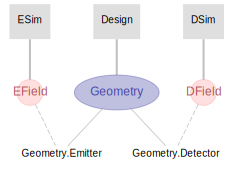

In [27]:
dj.Diagram(schema)